In [ ]:
# Dejar esta porción solo en caso de ejecutar en colab
from google.colab import drive
drive.mount('/gdrive')

# Nesesario para descomprimir carpeta con imagenes
!pip install unrar

# se leen las imagenes del conjunto de datos
!unrar x '/gdrive/My Drive/Dataset Yoga/Images.rar'

# Se recorren todas las imagenes y se eliminan las defectuosas
import os
from PIL import Image

# se obtiene la lista con todas las direcciones
path_list = []
for folder in os.listdir('Images'):
  if folder != '.DS_Store':
    for file in os.listdir('Images/'+ folder):
      path_list.append('Images/'+ folder+ '/'+file)

# se eliminan aquellas imagenes que no se pueden leer
for path in path_list:
  try:
    img = Image.open(path)
  except:
    os.remove(path)

In [2]:
# Librarías utilizadas
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms

# Modulos programados
import YogaDataset
from vit_model import MyViT
import train

In [3]:
# Se verifica que hay GPU disponible
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
IMG_SIZE = 224                  # tamaño deseado de las imagenes
images_dir = '/content/Images/' # carpeta con imagenes
LEVEL = 1                       # nivel de jerarquia usado en las clases

# transformacion aplicada a imagenes
data_transform = transforms.Compose([
    # se llevan al tamaño deseado
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    # se llevan a tensor y se normalizan
    transforms.ToTensor(),
])

# se crea el dataset con todas las imagenes
dataset = YogaDataset.YogaDataset(images_dir,
                                  data_transform,
                                  level = LEVEL)


# se separan los datos en conjuntos de entrenamiento, validacion y prueba
train_size = 16212
test_size = 2026
val_size = 2026
generator1 = torch.Generator().manual_seed(31415)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size], generator=generator1)

# se crean los dataloaders para cada conjunto de datos
BATCH_SIZE = 64
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
level_to_classes = {1:82,
                    2:20,
                    3:6}

# se cargan los parametros entrenados del modelo con menos clases
model = MyViT(num_classes=level_to_classes[3])
model.load_state_dict(torch.load('/gdrive/MyDrive/Dataset Yoga/best_model_vit_level_3.pt'))
model = model.cuda()

# se congelan los parametros
for parameter in model.parameters():
    parameter.requires_grad = False

# la ultima capa del clasificador se reemplaza por las dimensiones deseadas
model.mlp_head[1] = nn.Linear(in_features=768, out_features=level_to_classes[1]).to('cuda')

EPOCH: 1


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


LOSS train 4.304810047149658 valid 4.291302680969238 | ACC train 0.04015544041450777 val 0.037018756169792694
Modelo guardado en EPOCH 1
EPOCH: 2
LOSS train 4.297390937805176 valid 4.290362358093262 | ACC train 0.04027880582284727 val 0.038005923000987166
Modelo guardado en EPOCH 2
EPOCH: 3
LOSS train 4.295439720153809 valid 4.289851188659668 | ACC train 0.04021712311867752 val 0.0384995064165844
Modelo guardado en EPOCH 3
EPOCH: 4
LOSS train 4.293896675109863 valid 4.289572238922119 | ACC train 0.04064890204786578 val 0.03899308983218164
Modelo guardado en EPOCH 4
EPOCH: 5
LOSS train 4.292619228363037 valid 4.289394855499268 | ACC train 0.040957315568714535 val 0.0384995064165844
Modelo guardado en EPOCH 5
EPOCH: 6
LOSS train 4.291510581970215 valid 4.289257049560547 | ACC train 0.041018998272884286 val 0.0384995064165844
Modelo guardado en EPOCH 6
EPOCH: 7
LOSS train 4.2905168533325195 valid 4.289131164550781 | ACC train 0.04120404638539354 val 0.0384995064165844
Modelo guardado en E

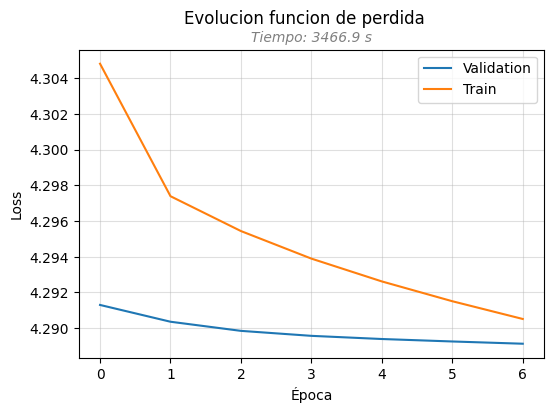

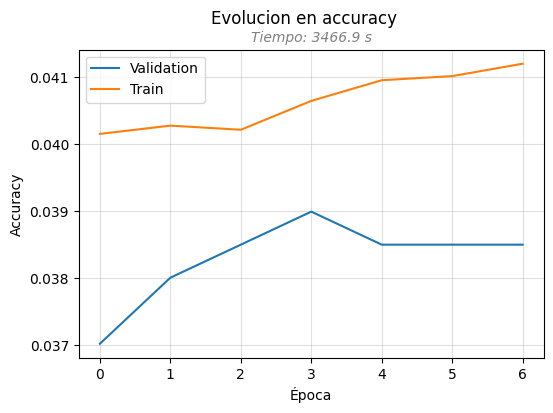

In [15]:
# hiperparametros
EPOCHS = 7           # maximo de epocas
lr = 0.003           # learning rate del optimizador
model_path = 'best_model_vit_transf_3_to_1.pt'


# se define la funcion de perdida
loss_fn = torch.nn.CrossEntropyLoss()
# se define el optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# se ejecuta el entrenamiento
results = train.train_model(model,
                      train_dataloader,
                      val_dataloader,
                      optimizer,
                      loss_fn,
                      EPOCHS,
                      model_path)

# se grafican los resultados
train.plot_results(results)

In [16]:
# se guardan los mejores parametros del modelo
!cp -r 'best_model_vit_transf_3_to_1.pt' '/gdrive/My Drive/Dataset Yoga/'

# se guardan las metricas resultantes del entrenamiento
import pickle
with open('results_vit_transf_3_to_1.pkl', 'wb') as f:
    pickle.dump(results, f)
!cp -r 'results_vit_transf_3_to_1.pkl' '/gdrive/My Drive/Dataset Yoga/'